# Load and display dataset

dataset's dimensions: (1797, 64)


<Figure size 640x480 with 0 Axes>

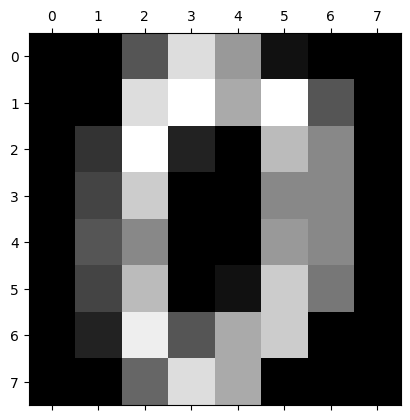

In [52]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Tuple, List
from numpy.typing import NDArray

digits = load_digits()
print("dataset's dimensions:", digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [53]:
# this function loads train and test sets from digits dataset
def load_data(batch_size):
    X = digits.data
    y = digits.target

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader
    

# Defining the NN with Pytorch

In [54]:
# Define the neural network
class SimpleNN(nn.Module):
    """3 Layer NN"""
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.hidden2(x))
        x = torch.softmax(self.output(x), dim=1)
        return x

# Plots the losses and accuracies of different optimizers

In [55]:
def plot_all_results(all_losses: NDArray, all_accuracies: NDArray, all_labels: List[str]) -> None:
    """ Plots and displays the losses and accuracies of different optimizers against each other
    
    :param all_losses: Losses of different optimizers
    :param all_accuracies: Accuracies of different optimizers
    :param all_labels: Names of different optimizers with their learning rate
    """
    if len(all_losses) != len(all_accuracies):
      raise ValueError("all_losses length must be equal to all_accuracies length")

    if len(all_losses) != len(all_labels):
      raise ValueError("all_labels length must be equal to all_losses length")

    epochs = len(all_losses[0])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_losses[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title(f'Training loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_accuracies[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title(f'Training accuracy')

    plt.legend()
    plt.show()

# Training Loop

In [56]:
def test_model(test_loader, model, criterion, output_size) -> Tuple[float, float]:
    """ Test the model on the test dataset
    
    :param test_loader: test loader 
    :param model: the model to test
    :param criterion: the loss function
    :param output_size: the output size
    :return: loss and accuracy of the current epoch
    """
    loss = 0
    total = 0 # total items in test set
    correct = 0 # number of correct preds
    iterations = 0
    
    for i, data in  enumerate(test_loader):
        iterations += 1
        inputs, labels = data
        
        # One-hot encode the labels
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=output_size).float()
        
        # Forward pass
        outputs = model(inputs)
        loss += criterion(outputs, labels_one_hot)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return loss.item() / iterations, correct / total
        

def train_one_epoch(model, train_loader, optimizer, criterion, output_size) -> None:
    """Trains the model for 1 epoch
    
    :param model: the NN to train
    :param train_loader: the training loader
    :param optimizer: the optimizer to use
    :param criterion: the loss function
    :param output_size: the output size
    """
    for i, data in  enumerate(train_loader):
        inputs, labels = data
        
        # One-hot encode the labels
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=output_size).float()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels_one_hot)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
            
        optimizer.step()
        

def train(model, data, optimizer, training_epochs, output_size, criterion) -> Tuple[List[float], List[float]]:
    """Trains the model for a given amount of epochs and returns the loss and accuracy of the model
    
    :param model: the NN to train
    :param data: the training and testing data
    :param optimizer: the optimizer to use
    :param training_epochs: number of epochs to train for
    :param output_size: the output size
    :param criterion: the loss function to use
    :return: test loss and accuracy of the model
    """
    train_loader, test_loader = data
    test_losses = []
    test_accuracies = []
    
    for epoch in range(training_epochs):
        train_one_epoch(model, train_loader, optimizer, criterion, output_size)
    
        loss, accuracy = test_model(test_loader, model, criterion, output_size)
        test_losses.append(loss)
        test_accuracies.append(accuracy)
        if epoch % 20 == 19:
            print(f'Epoch [{epoch+1}/{training_epochs}], Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    
    return test_losses, test_accuracies

Training with SGD: LR=0.5
Epoch [20/200], Loss: 0.0895, Accuracy: 24.72%
Epoch [40/200], Loss: 0.0890, Accuracy: 31.94%
Epoch [60/200], Loss: 0.0883, Accuracy: 31.11%
Epoch [80/200], Loss: 0.0874, Accuracy: 36.67%
Epoch [100/200], Loss: 0.0861, Accuracy: 38.61%
Epoch [120/200], Loss: 0.0844, Accuracy: 39.72%
Epoch [140/200], Loss: 0.0820, Accuracy: 39.17%
Epoch [160/200], Loss: 0.0790, Accuracy: 44.44%
Epoch [180/200], Loss: 0.0753, Accuracy: 47.22%
Epoch [200/200], Loss: 0.0713, Accuracy: 49.72%
Training with SGD: LR=0.2
Epoch [20/200], Loss: 0.0904, Accuracy: 9.72%
Epoch [40/200], Loss: 0.0899, Accuracy: 13.06%
Epoch [60/200], Loss: 0.0896, Accuracy: 21.94%
Epoch [80/200], Loss: 0.0894, Accuracy: 23.61%
Epoch [100/200], Loss: 0.0892, Accuracy: 26.67%
Epoch [120/200], Loss: 0.0890, Accuracy: 31.11%
Epoch [140/200], Loss: 0.0888, Accuracy: 32.78%
Epoch [160/200], Loss: 0.0886, Accuracy: 39.17%
Epoch [180/200], Loss: 0.0884, Accuracy: 43.61%
Epoch [200/200], Loss: 0.0881, Accuracy: 44.1

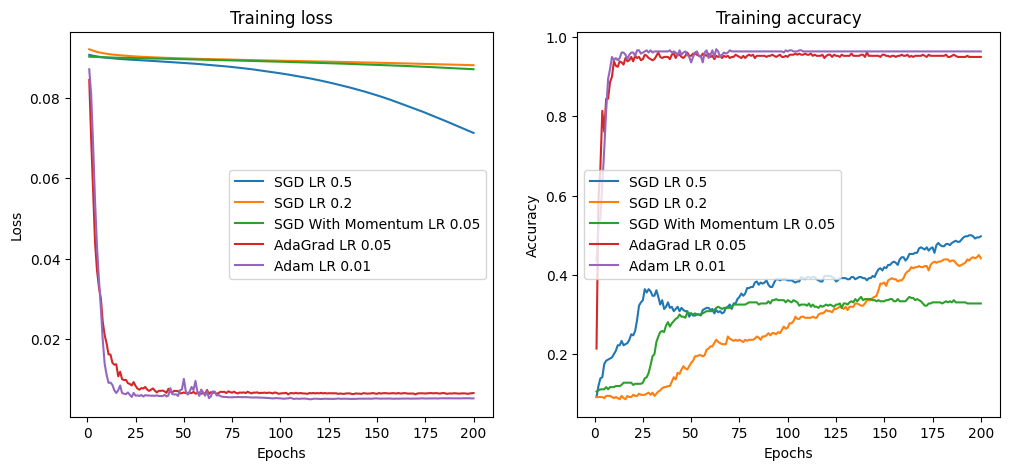

In [58]:
# Main function to run the experiments
def main():
    batch_size = 128
    input_size = 64  # For the digits dataset (8x8 images flattened)
    hidden_size = 20
    output_size = 10
    epochs = 200
    data = load_data(batch_size)
    criterion = nn.MSELoss()

    print("Training with SGD: LR=0.5")
    model = SimpleNN(input_size, hidden_size, output_size)
    optimizer = optim.SGD(model.parameters(), lr=0.5)
    SGD_a_loss, SGD_a_accuracy = train(model, data, optimizer, epochs, output_size, criterion)
    
    print("Training with SGD: LR=0.2")
    model = SimpleNN(input_size, hidden_size, output_size)
    optimizer = optim.SGD(model.parameters(), lr=0.2)
    SGD_b_loss, SGD_b_accuracy = train(model, data, optimizer, epochs, output_size, criterion)
    
    print("Training with SGD with Momentum: LR=0.05, momentum=0.8")
    model = SimpleNN(input_size, hidden_size, output_size)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.8)
    SGD_Momentum_loss, SGD_Momentum_accuracy = train(model, data, optimizer, epochs, output_size, criterion)
    
    print("Training with AdaGrad: LR=0.05")
    model = SimpleNN(input_size, hidden_size, output_size)
    optimizer = optim.Adagrad(model.parameters(), lr=0.05, eps=1e-8)
    SGD_AdaGrad_loss, SGD_AdaGrad_accuracy = train(model, data, optimizer, epochs, output_size, criterion)
    
    print("Training with Adam: LR=0.01, betas=(0.9, 0.999)")
    model = SimpleNN(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    SGD_Adam_loss, SGD_Adam_accuracy = train(model, data, optimizer, epochs, output_size, criterion)
    
    # Compare train losses and train accuracies
    all_losses = [SGD_a_loss, SGD_b_loss, SGD_Momentum_loss, SGD_AdaGrad_loss, SGD_Adam_loss]
    all_accuracies = [SGD_a_accuracy, SGD_b_accuracy, SGD_Momentum_accuracy, SGD_AdaGrad_accuracy, SGD_Adam_accuracy]
    all_labels = ["SGD LR 0.5", "SGD LR 0.2", "Momentum LR 0.05", "AdaGrad LR 0.05", "Adam LR 0.01"]
    plot_all_results(all_losses, all_accuracies, all_labels)
    
if __name__ == "__main__":
    main()